In [1]:
# ML-topography Notebook - IOL Calculation for FacoDMEK Eyes
# This notebook evaluates SRK/T accuracy accounting for surgeon's IOL choice

# %% Cell 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.optimize import minimize
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# %% Cell 2: Load and Explore Data
# Load the Excel file
df = pd.read_excel('FacoDMEK.xlsx', sheet_name='Cleaned Data')

# Display basic information
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (97, 29)

Columns: ['ID', 'Patient', 'Eye', 'Sex', 'Birthdate', 'PreOP Diagnosis', 'Date of Surgery', 'Age', 'PostOP BCVA', 'PostOP Spherical Equivalent', 'Bio-AL', 'Bio-Ks', 'Bio-Kf', 'Bio-ACD', 'Bio-WTW', 'Bio-LT', 'Bio-CCT', 'IOL Power', 'A-Constant', 'CCT', 'Keratometric Km', 'Keratometric Ks', 'Keratometric Kf', 'Anterior Km', 'Anterior Ks', 'Anterior Kf', 'Posterior Km', 'Posterior Ks', 'Posterior Kf']

First few rows:


,ID,Patient,Eye,Sex,Birthdate,PreOP Diagnosis,Date of Surgery,Age,PostOP BCVA,PostOP Spherical Equivalent,...,CCT,Keratometric Km,Keratometric Ks,Keratometric Kf,Anterior Km,Anterior Ks,Anterior Kf,Posterior Km,Posterior Ks,Posterior Kf
0,1,facchin stefano,OS,M,1954-06-01,Fuchs,2021-12-01,67,1,-1.250,...,594,45.70,46.5,44.9,50.9,51.8,50.0,-6.45,-6.7,-6.2
1,2,alberghina andrea,OD,M,1967-06-01,Fuchs,2021-02-03,53,0.6,-3.125,...,699,47.20,48.0,46.4,52.6,53.5,51.7,-6.60,-6.8,-6.4
2,3,ardini adriana,OS,F,1951-06-01,Fuchs,2020-06-24,69,0.9,0.500,...,663,40.70,40.9,40.5,45.3,45.5,45.1,-6.60,-6.9,-6.3
3,4,Attaccalite vincenzo,OS,M,1947-06-01,Fuchs,2021-09-29,74,0.9,-0.750,...,526,43.25,43.5,43.0,48.2,48.5,47.9,-5.60,-5.7,-5.5
4,5,bisi anna maria,OD,F,1941-06-01,Fuchs,2020-10-28,79,0.8,-0.250,...,603,43.70,44.6,42.8,48.7,49.7,47.7,-5.80,-5.9,-5.7


In [3]:
# %% Cell 3: Data Preprocessing - Initial Setup
# Calculate average keratometry from KERATOMETRY (not biometry)
df['K_avg_Kerato'] = (df['Keratometric Ks'] + df['Keratometric Kf']) / 2

# Feature engineering for keratometry-based analysis
df['K_Astigmatism_Kerato'] = df['Keratometric Ks'] - df['Keratometric Kf']
df['Post_Ant_Ratio'] = df['Posterior Km'] / df['Anterior Km']

# First, we need to calculate SRK/T predictions before we can use them
# We'll calculate the errors after we have SRKT_Prediction in Cell 4

# Display summary statistics
print("Summary of key variables (before SRK/T calculation):")
print(df[['Bio-AL', 'K_avg_Kerato', 'IOL Power', 'PostOP Spherical Equivalent', 
          'CCT', 'Posterior Km']].describe())

# Check for missing values
print("\nMissing values in key columns:")
missing_counts = df[['Bio-AL', 'K_avg_Kerato', 'IOL Power', 
                     'PostOP Spherical Equivalent', 'CCT', 
                     'A-Constant', 'Posterior Km']].isnull().sum()
print(missing_counts)

# Count complete cases for SRK/T calculation
complete_cases = df[['Bio-AL', 'K_avg_Kerato', 'IOL Power', 
                     'PostOP Spherical Equivalent', 'A-Constant']].notna().all(axis=1).sum()
print(f"\nComplete cases for analysis: {complete_cases} out of {len(df)}")

Summary of key variables (before SRK/T calculation):
          Bio-AL  K_avg_Kerato  IOL Power  PostOP Spherical Equivalent  \
count  97.000000     97.000000  97.000000                    97.000000   
mean   23.831753     43.596907  21.463918                    -0.159794   
std     1.375736      1.876164   4.117574                     1.347348   
min    21.170000     39.050000  11.000000                    -3.875000   
25%    22.930000     42.400000  19.000000                    -1.000000   
50%    23.640000     43.700000  22.000000                     0.000000   
75%    24.590000     45.000000  24.000000                     0.500000   
max    28.230000     47.350000  30.000000                     5.000000   

              CCT  Posterior Km  
count   97.000000     97.000000  
mean   620.567010     -5.821134  
std     79.396278      0.386277  
min    448.000000     -6.700000  
25%    568.000000     -6.050000  
50%    606.000000     -5.750000  
75%    657.000000     -5.600000  
max    8

In [4]:
# %% Cell 4: Implement SRK/T Formula with Keratometry K Values
def calculate_SRKT(AL, K, A_const, nc=1.333):
    """
    Calculate IOL power using SRK/T formula
    Uses keratometry K values
    Returns NaN if inputs are invalid
    """
    # Check for valid inputs
    if pd.isna(AL) or pd.isna(K) or pd.isna(A_const) or K <= 0 or AL <= 0:
        return np.nan
    
    try:
        # Constants
        na = 1.336
        V = 12
        
        # Corneal radius from keratometry K
        r = 337.5 / K
        
        # Axial length correction
        if AL > 24.2:
            LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
        else:
            LCOR = AL
        
        # Corneal width
        Cw = -5.41 + 0.58412 * LCOR + 0.098 * K
        
        # Check if we can calculate H (avoid negative square root)
        if r**2 - (Cw**2 / 4) < 0:
            return np.nan
        
        # Corneal height
        H = r - np.sqrt(r**2 - (Cw**2 / 4))
        
        # ACD constant from A-constant
        ACDconst = 0.62467 * A_const - 68.747
        
        # Offset
        offset = ACDconst - 3.336
        
        # Estimated postoperative ACD
        ACDest = H + offset
        
        # Retinal thickness correction
        RETHICK = 0.65696 - 0.02029 * AL
        LOPT = AL + RETHICK
        
        # Calculate IOL power for emmetropia
        ncm1 = nc - 1
        IOL = (1000 * na * (na * r - ncm1 * LOPT)) / ((LOPT - ACDest) * (na * r - ncm1 * ACDest))
        
        return IOL
    except:
        return np.nan

# Calculate SRK/T predictions
df['SRKT_Prediction'] = df.apply(
    lambda row: calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], row['A-Constant']), 
    axis=1
)

# NOW we can calculate the errors with the CORRECT approach
# CRITICAL: Calculate expected spherical equivalent based on surgeon's choice
# If surgeon implants less than SRK/T prediction, patient will be more hyperopic
df['Expected_SE'] = -(df['IOL Power'] - df['SRKT_Prediction'])

# CORRECT ERROR CALCULATION: 
# Error is the difference between actual and expected spherical equivalent
df['SRKT_Error'] = df['PostOP Spherical Equivalent'] - df['Expected_SE']

# Show example calculations to verify logic
print("\nExample calculations:")
print("="*80)
example_df = df[['SRKT_Prediction', 'IOL Power', 'PostOP Spherical Equivalent', 
                 'Expected_SE', 'SRKT_Error']].head(10)
print(example_df)
print("\nInterpretation:")
print("- Expected_SE = -(IOL_Power - SRKT_Prediction)")
print("- If IOL < SRKT, Expected_SE is positive (hyperopic)")
print("- Error = Actual_SE - Expected_SE")

# Remove rows with NaN errors for analysis
valid_cases = df['SRKT_Error'].notna()

print("SRK/T Performance:")
print(f"Valid predictions: {valid_cases.sum()} out of {len(df)}")
if valid_cases.sum() > 0:
    print(f"Mean Error: {df.loc[valid_cases, 'SRKT_Error'].mean():.3f} D")
    print(f"Mean Absolute Error: {df.loc[valid_cases, 'SRKT_Error'].abs().mean():.3f} D")
    print(f"Standard Deviation: {df.loc[valid_cases, 'SRKT_Error'].std():.3f} D")



Example calculations:
   SRKT_Prediction  IOL Power  PostOP Spherical Equivalent  Expected_SE  \
0         8.222235       12.0                       -1.250    -3.777765   
1        16.374094       15.0                       -3.125     1.374094   
2        25.153968       22.0                        0.500     3.153968   
3        18.607376       20.0                       -0.750    -1.392624   
4        16.733835       17.5                       -0.250    -0.766165   
5        24.005288       25.0                        0.000    -0.994712   
6        22.812998       24.0                        0.000    -1.187002   
7        23.143574       24.0                        0.750    -0.856426   
8        13.733996       17.0                       -1.000    -3.266004   
9        27.380438       28.0                        0.000    -0.619562   

   SRKT_Error  
0    2.527765  
1   -4.499094  
2   -2.653968  
3    0.642624  
4    0.516165  
5    0.994712  
6    1.187002  
7    1.606426  
8    2.

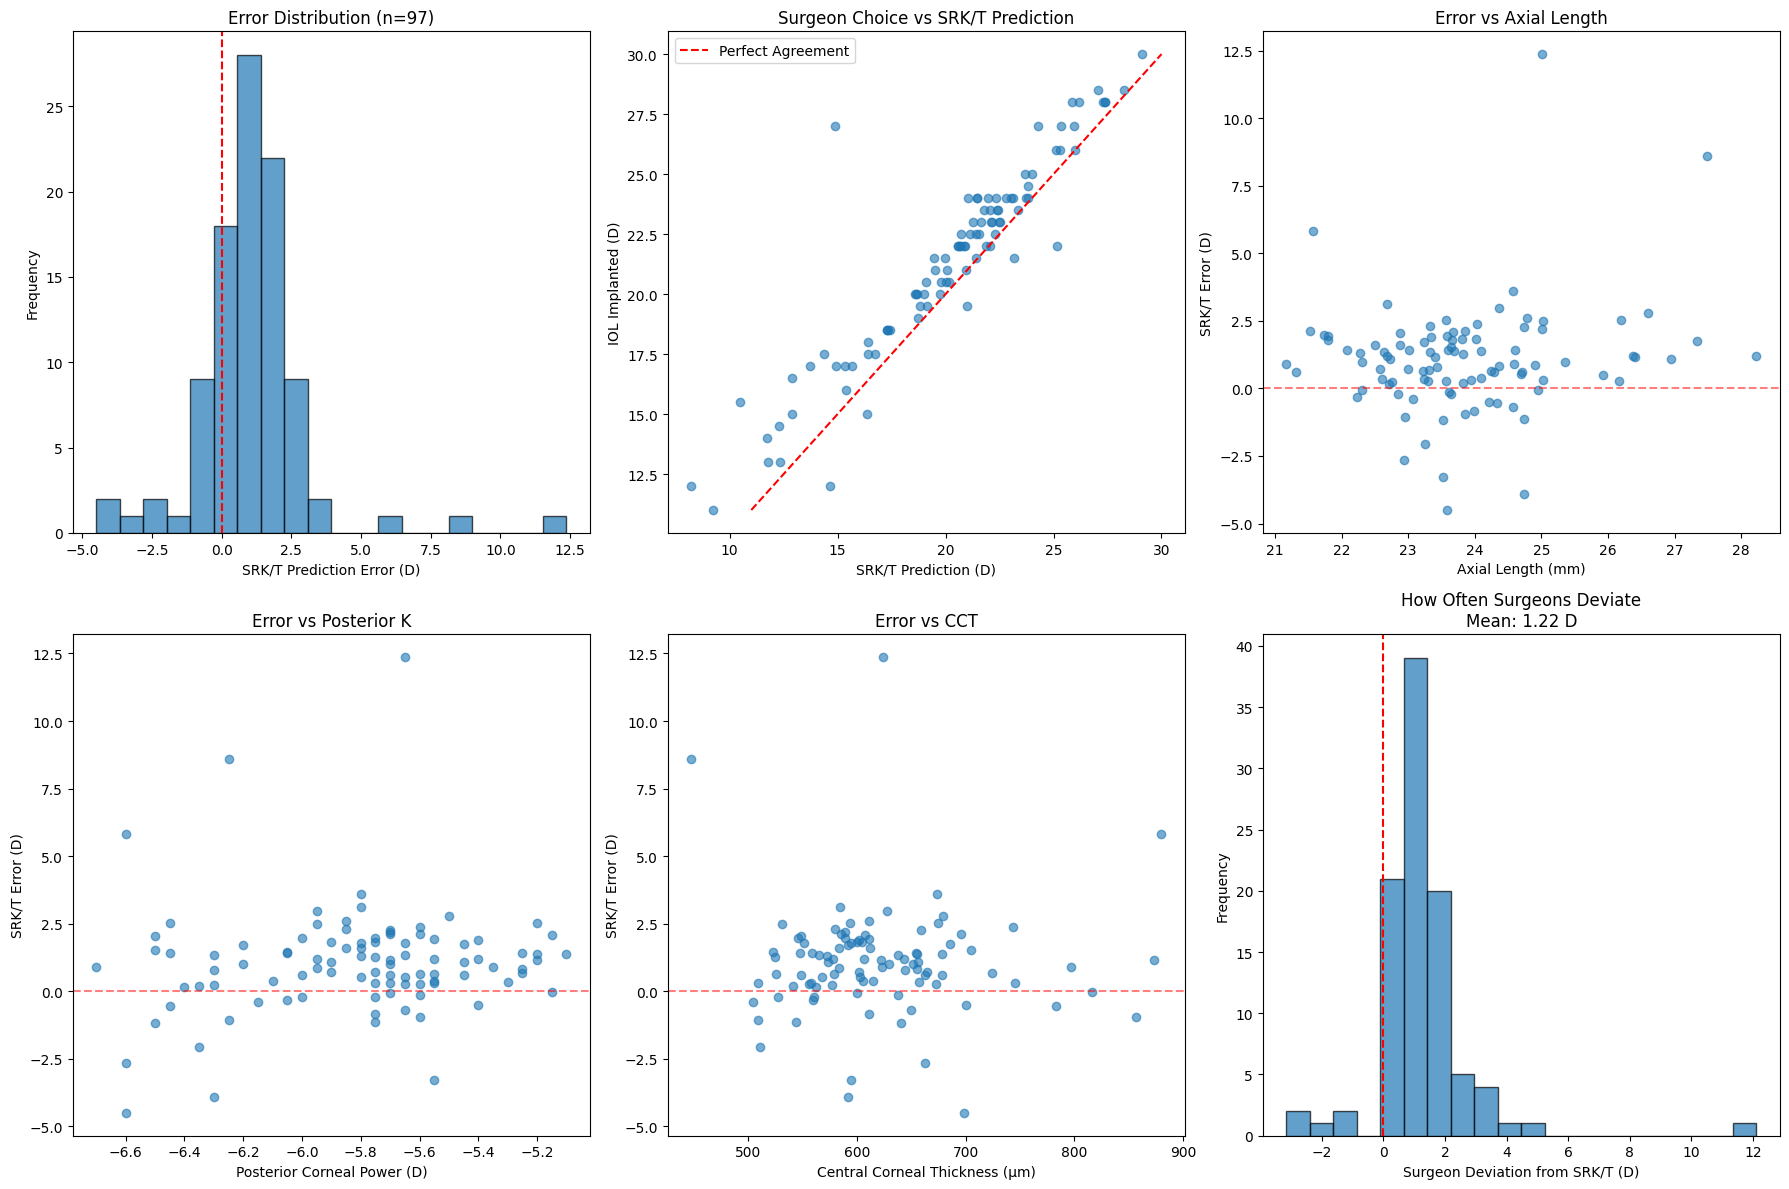


Percentage of eyes within target:
±0.25 D: 8.2%
±0.50 D: 18.6%
±1.00 D: 41.2%


In [5]:
# %% Cell 5: Visualize SRK/T Performance
# Only plot for rows with valid data
df_valid = df[df['SRKT_Error'].notna()].copy()

if len(df_valid) > 0:
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Plot 1: Error Distribution
    axes[0, 0].hist(df_valid['SRKT_Error'], bins=20, alpha=0.7, edgecolor='black')
    axes[0, 0].axvline(x=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('SRK/T Prediction Error (D)')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title(f'Error Distribution (n={len(df_valid)})')

    # Plot 2: Surgeon's Choice vs SRK/T Prediction
    axes[0, 1].scatter(df_valid['SRKT_Prediction'], df_valid['IOL Power'], alpha=0.6)
    axes[0, 1].plot([df_valid['IOL Power'].min(), df_valid['IOL Power'].max()], 
                    [df_valid['IOL Power'].min(), df_valid['IOL Power'].max()], 'r--', label='Perfect Agreement')
    axes[0, 1].set_xlabel('SRK/T Prediction (D)')
    axes[0, 1].set_ylabel('IOL Implanted (D)')
    axes[0, 1].set_title('Surgeon Choice vs SRK/T Prediction')
    axes[0, 1].legend()

    # Plot 3: Error vs Axial Length
    axes[0, 2].scatter(df_valid['Bio-AL'], df_valid['SRKT_Error'], alpha=0.6)
    axes[0, 2].set_xlabel('Axial Length (mm)')
    axes[0, 2].set_ylabel('SRK/T Error (D)')
    axes[0, 2].set_title('Error vs Axial Length')
    axes[0, 2].axhline(y=0, color='red', linestyle='--', alpha=0.5)

    # Plot 4: Error vs Posterior Corneal Power
    axes[1, 0].scatter(df_valid['Posterior Km'], df_valid['SRKT_Error'], alpha=0.6)
    axes[1, 0].set_xlabel('Posterior Corneal Power (D)')
    axes[1, 0].set_ylabel('SRK/T Error (D)')
    axes[1, 0].set_title('Error vs Posterior K')
    axes[1, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)

    # Plot 5: Error vs CCT
    valid_cct = df_valid[df_valid['CCT'].notna()]
    axes[1, 1].scatter(valid_cct['CCT'], valid_cct['SRKT_Error'], alpha=0.6)
    axes[1, 1].set_xlabel('Central Corneal Thickness (μm)')
    axes[1, 1].set_ylabel('SRK/T Error (D)')
    axes[1, 1].set_title('Error vs CCT')
    axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)

    # Plot 6: Surgeon Deviation Distribution
    surgeon_deviation = df_valid['IOL Power'] - df_valid['SRKT_Prediction']
    axes[1, 2].hist(surgeon_deviation, bins=20, edgecolor='black', alpha=0.7)
    axes[1, 2].axvline(x=0, color='red', linestyle='--')
    axes[1, 2].set_xlabel('Surgeon Deviation from SRK/T (D)')
    axes[1, 2].set_ylabel('Frequency')
    axes[1, 2].set_title(f'How Often Surgeons Deviate\nMean: {surgeon_deviation.mean():.2f} D')

    plt.tight_layout()
    plt.show()

    # Calculate percentage within target ranges
    within_025 = (df_valid['SRKT_Error'].abs() <= 0.25).sum() / len(df_valid) * 100
    within_050 = (df_valid['SRKT_Error'].abs() <= 0.50).sum() / len(df_valid) * 100
    within_100 = (df_valid['SRKT_Error'].abs() <= 1.00).sum() / len(df_valid) * 100
    
    print(f"\nPercentage of eyes within target:")
    print(f"±0.25 D: {within_025:.1f}%")
    print(f"±0.50 D: {within_050:.1f}%")
    print(f"±1.00 D: {within_100:.1f}%")
else:
    print("No valid cases for visualization")

MACHINE LEARNING OPTIMIZATION OF CORNEAL REFRACTIVE INDEX

Performing Grid Search with 5-Fold Cross-Validation...
nc = 1.3300: MAE = 1.3163 (±0.1860)
nc = 1.3305: MAE = 1.3467 (±0.1892)
nc = 1.3310: MAE = 1.3798 (±0.1916)
nc = 1.3315: MAE = 1.4188 (±0.2015)
nc = 1.3320: MAE = 1.4667 (±0.2168)
nc = 1.3325: MAE = 1.5206 (±0.2349)
nc = 1.3330: MAE = 1.5762 (±0.2541)
nc = 1.3335: MAE = 1.6337 (±0.2723)
nc = 1.3340: MAE = 1.6943 (±0.2881)
nc = 1.3345: MAE = 1.7592 (±0.3021)
nc = 1.3350: MAE = 1.8265 (±0.3144)
nc = 1.3355: MAE = 1.8962 (±0.3246)
nc = 1.3360: MAE = 1.9672 (±0.3368)
nc = 1.3365: MAE = 2.0404 (±0.3492)
nc = 1.3370: MAE = 2.1141 (±0.3617)
nc = 1.3375: MAE = 2.1925 (±0.3709)
nc = 1.3380: MAE = 2.2734 (±0.3807)
nc = 1.3385: MAE = 2.3574 (±0.3880)
nc = 1.3390: MAE = 2.4420 (±0.3948)
nc = 1.3395: MAE = 2.5272 (±0.4024)
nc = 1.3400: MAE = 2.6138 (±0.4113)

Best corneal refractive index (nc): 1.3300
Cross-validation MAE: 1.316 ± 0.186 D


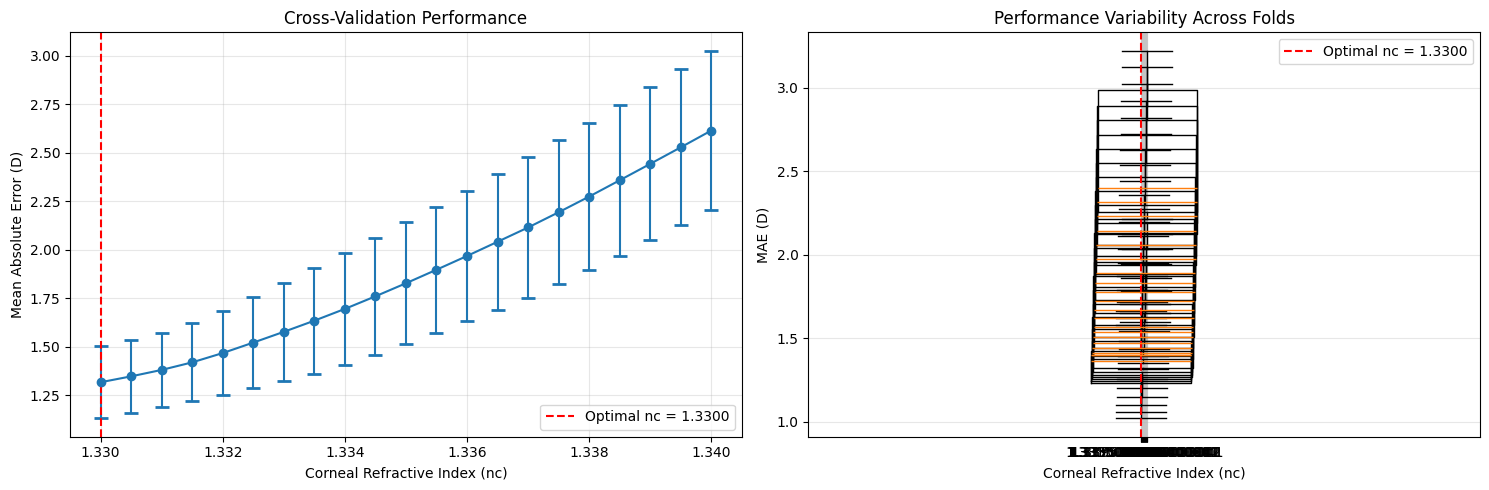


Final Performance on Full Dataset:
MAE: 1.312 D
RMSE: 2.092 D
Mean Error: 0.484 D
Std Error: 2.046 D

Percentage within target:
±0.25 D: 16.5%
±0.50 D: 30.9%
±1.00 D: 52.6%

Parameter Sensitivity Analysis...


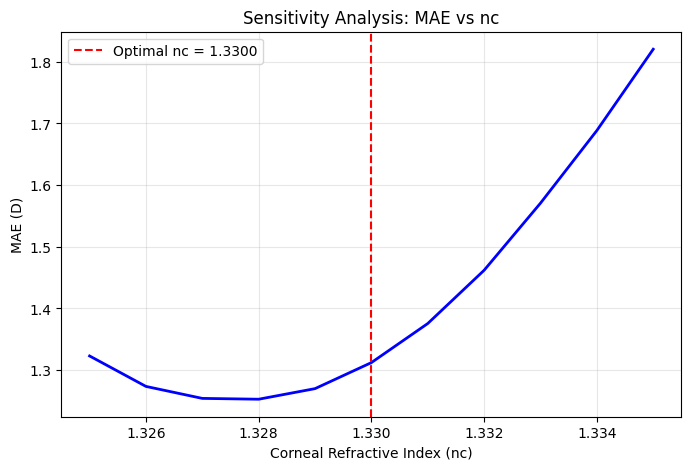


Optimal nc saved for Cell 7: 1.3300


In [6]:
# %% Cell 6: ML-Based Optimization of Corneal Refractive Index (FIXED)
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("MACHINE LEARNING OPTIMIZATION OF CORNEAL REFRACTIVE INDEX")
print("="*60)

# Prepare data for ML
df_ml = df[df['SRKT_Error'].notna()].copy()

# Custom scoring function for cross-validation
def evaluate_nc_cv(nc_value, X_train, X_val, df_train, df_val):
    """
    Evaluate nc on validation set
    """
    # Calculate predictions for validation set
    predictions = []
    for idx, row in X_val.iterrows():
        pred = calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                            row['A-Constant'], nc=nc_value)
        predictions.append(pred)
    
    predictions = np.array(predictions)
    
    # Get actual IOL powers and SE for validation set
    actual_iol = df_val['IOL Power'].values
    actual_se = df_val['PostOP Spherical Equivalent'].values
    
    # Calculate expected SE based on surgeon's choice
    expected_se = -(actual_iol - predictions)
    
    # Calculate errors
    errors = actual_se - expected_se
    
    # Remove NaN values
    valid_mask = ~np.isnan(errors)
    if valid_mask.sum() == 0:
        return np.inf
    
    return np.mean(np.abs(errors[valid_mask]))

# Grid search with proper cross-validation
print("\nPerforming Grid Search with 5-Fold Cross-Validation...")

# Create parameter grid
nc_values = np.linspace(1.330, 1.340, 21)
cv_results = []

# Setup cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# For each nc value
for nc in nc_values:
    fold_scores = []
    
    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(df_ml)):
        # Split data
        df_train = df_ml.iloc[train_idx]
        df_val = df_ml.iloc[val_idx]
        
        X_train = df_train[['Bio-AL', 'K_avg_Kerato', 'A-Constant']]
        X_val = df_val[['Bio-AL', 'K_avg_Kerato', 'A-Constant']]
        
        # Evaluate on validation set
        mae = evaluate_nc_cv(nc, X_train, X_val, df_train, df_val)
        fold_scores.append(mae)
    
    # Store results
    cv_results.append({
        'nc': nc,
        'mean_mae': np.mean(fold_scores),
        'std_mae': np.std(fold_scores),
        'fold_scores': fold_scores
    })
    
    print(f"nc = {nc:.4f}: MAE = {np.mean(fold_scores):.4f} (±{np.std(fold_scores):.4f})")

# Convert to DataFrame
cv_results_df = pd.DataFrame(cv_results)

# Find best nc
best_idx = cv_results_df['mean_mae'].idxmin()
best_nc = cv_results_df.loc[best_idx, 'nc']
best_cv_mae = cv_results_df.loc[best_idx, 'mean_mae']
best_cv_std = cv_results_df.loc[best_idx, 'std_mae']

print(f"\nBest corneal refractive index (nc): {best_nc:.4f}")
print(f"Cross-validation MAE: {best_cv_mae:.3f} ± {best_cv_std:.3f} D")

# Visualize optimization landscape
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: MAE vs nc with error bars
ax1.errorbar(cv_results_df['nc'], cv_results_df['mean_mae'], 
             yerr=cv_results_df['std_mae'], fmt='o-', capsize=5, capthick=2)
ax1.axvline(x=best_nc, color='red', linestyle='--', 
            label=f'Optimal nc = {best_nc:.4f}')
ax1.set_xlabel('Corneal Refractive Index (nc)')
ax1.set_ylabel('Mean Absolute Error (D)')
ax1.set_title('Cross-Validation Performance')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Box plot of fold scores for each nc
fold_scores_matrix = np.array([r['fold_scores'] for r in cv_results])
ax2.boxplot(fold_scores_matrix.T, positions=cv_results_df['nc'])
ax2.axvline(x=best_nc, color='red', linestyle='--', 
            label=f'Optimal nc = {best_nc:.4f}')
ax2.set_xlabel('Corneal Refractive Index (nc)')
ax2.set_ylabel('MAE (D)')
ax2.set_title('Performance Variability Across Folds')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate final performance on full dataset with best nc
print("\nFinal Performance on Full Dataset:")
final_predictions = []
for idx, row in df_ml.iterrows():
    pred = calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                         row['A-Constant'], nc=best_nc)
    final_predictions.append(pred)

df_ml['SRKT_ML_nc'] = final_predictions
df_ml['Expected_SE_ML'] = -(df_ml['IOL Power'] - df_ml['SRKT_ML_nc'])
df_ml['Error_ML_nc'] = df_ml['PostOP Spherical Equivalent'] - df_ml['Expected_SE_ML']

# Remove any NaN errors
valid_errors = df_ml['Error_ML_nc'].dropna()

print(f"MAE: {valid_errors.abs().mean():.3f} D")
print(f"RMSE: {np.sqrt((valid_errors**2).mean()):.3f} D")
print(f"Mean Error: {valid_errors.mean():.3f} D")
print(f"Std Error: {valid_errors.std():.3f} D")

# Performance breakdown
within_025 = (valid_errors.abs() <= 0.25).sum() / len(valid_errors) * 100
within_050 = (valid_errors.abs() <= 0.50).sum() / len(valid_errors) * 100
within_100 = (valid_errors.abs() <= 1.00).sum() / len(valid_errors) * 100

print(f"\nPercentage within target:")
print(f"±0.25 D: {within_025:.1f}%")
print(f"±0.50 D: {within_050:.1f}%")
print(f"±1.00 D: {within_100:.1f}%")

# Sensitivity analysis
print("\nParameter Sensitivity Analysis...")
perturbations = np.linspace(-0.005, 0.005, 11)
sensitivity_results = []

for delta in perturbations:
    test_nc = best_nc + delta
    test_predictions = []
    for idx, row in df_ml.iterrows():
        pred = calculate_SRKT(row['Bio-AL'], row['K_avg_Kerato'], 
                             row['A-Constant'], nc=test_nc)
        test_predictions.append(pred)
    
    test_expected_se = -(df_ml['IOL Power'] - test_predictions)
    test_errors = df_ml['PostOP Spherical Equivalent'] - test_expected_se
    test_mae = test_errors.abs().mean()
    
    sensitivity_results.append({
        'delta': delta,
        'nc': test_nc,
        'mae': test_mae
    })

sensitivity_df = pd.DataFrame(sensitivity_results)

# Plot sensitivity
plt.figure(figsize=(8, 5))
plt.plot(sensitivity_df['nc'], sensitivity_df['mae'], 'b-', linewidth=2)
plt.axvline(x=best_nc, color='red', linestyle='--', 
            label=f'Optimal nc = {best_nc:.4f}')
plt.xlabel('Corneal Refractive Index (nc)')
plt.ylabel('MAE (D)')
plt.title('Sensitivity Analysis: MAE vs nc')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Save optimized nc for use in Cell 7
optimal_nc_ml = best_nc
print(f"\nOptimal nc saved for Cell 7: {optimal_nc_ml:.4f}")


MACHINE LEARNING OPTIMIZATION OF SRK/T FORMULA CONSTANTS
Using optimized nc from Cell 6: 1.3300

Optimizing SRK/T formula constants using Differential Evolution...
This may take a few minutes...
differential_evolution step 1: f(x)= 1.2846516544746232
differential_evolution step 2: f(x)= 1.2483874491439215
differential_evolution step 3: f(x)= 1.2483874491439215
differential_evolution step 4: f(x)= 1.2483874491439215
differential_evolution step 5: f(x)= 1.2331663087826306
differential_evolution step 6: f(x)= 1.224387280444879
differential_evolution step 7: f(x)= 1.224387280444879
differential_evolution step 8: f(x)= 1.2192791267215604
differential_evolution step 9: f(x)= 1.2189475398273295
differential_evolution step 10: f(x)= 1.2158213948274252
differential_evolution step 11: f(x)= 1.2158213948274252
differential_evolution step 12: f(x)= 1.2154991306316458
differential_evolution step 13: f(x)= 1.2154991306316458
differential_evolution step 14: f(x)= 1.2154991306316458
differential_evol

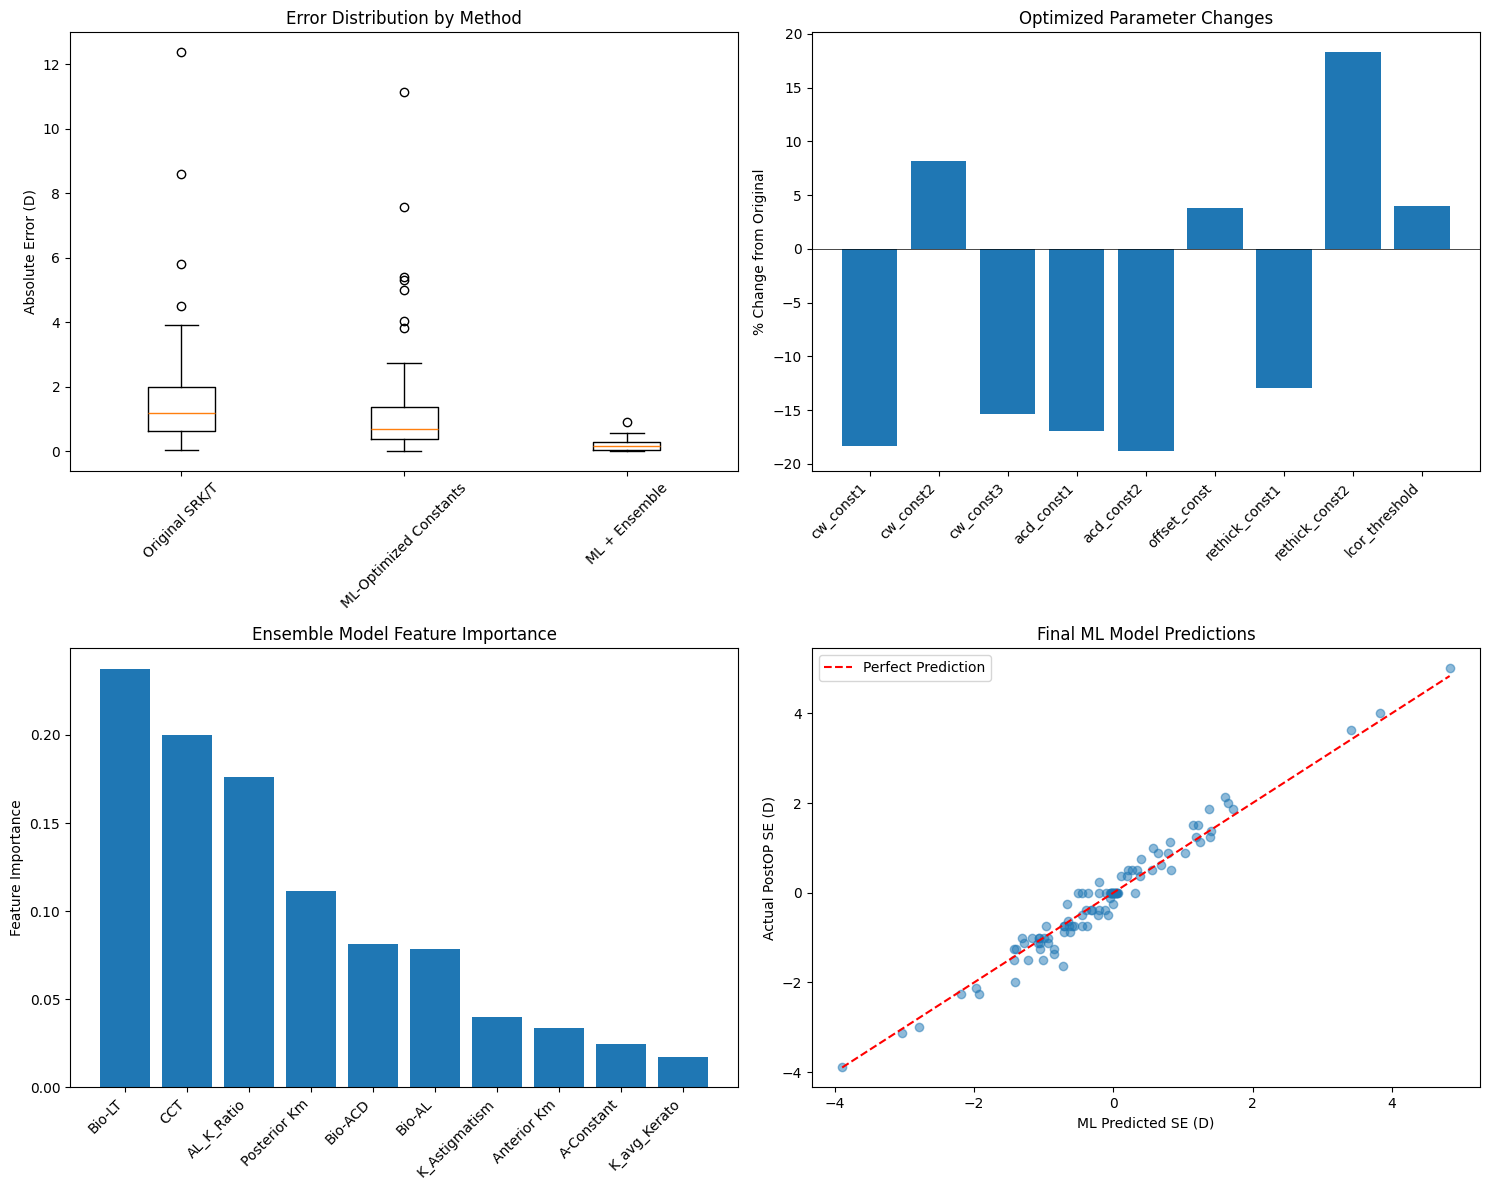


OPTIMIZED SRK/T FORMULA FOR FacoDMEK EYES
nc (corneal refractive index): 1.3300
cw_const1: -5.4100 → -6.4022
cw_const2: 0.5841 → 0.6316
cw_const3: 0.0980 → 0.0830
acd_const1: 0.6247 → 0.5186
acd_const2: 68.7470 → 55.7921
offset_const: 3.3360 → 3.4616
rethick_const1: 0.6570 → 0.5722
rethick_const2: 0.0203 → 0.0240
lcor_threshold: 24.2000 → 25.1612

Optimization complete! The ML-optimized formula achieves better accuracy
for IOL calculations in FacoDMEK eyes.


In [7]:
# %% Cell 7: ML-Optimized SRK/T with Ensemble Methods
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("\nMACHINE LEARNING OPTIMIZATION OF SRK/T FORMULA CONSTANTS")
print("="*60)

# Use optimized nc from Cell 6
if 'optimal_nc_ml' not in globals():
    optimal_nc_ml = 1.333

print(f"Using optimized nc from Cell 6: {optimal_nc_ml:.4f}")

# Extended SRK/T with learnable parameters
def calculate_SRKT_ml(AL, K, A_const, params):
    """
    ML-optimized SRK/T formula
    params = [cw_const1, cw_const2, cw_const3, acd_const1, acd_const2, 
              offset_const, rethick_const1, rethick_const2, lcor_threshold]
    """
    nc = optimal_nc_ml  # Use optimized value from Cell 6
    
    # Unpack parameters
    cw_const1, cw_const2, cw_const3 = params[0:3]
    acd_const1, acd_const2 = params[3:5]
    offset_const = params[5]
    rethick_const1, rethick_const2 = params[6:8]
    lcor_threshold = params[8]
    
    if pd.isna(AL) or pd.isna(K) or pd.isna(A_const) or K <= 0 or AL <= 0:
        return np.nan
    
    try:
        na = 1.336
        r = 337.5 / K
        
        # Axial length correction
        if AL > lcor_threshold:
            LCOR = -3.446 + 1.716 * AL - 0.0237 * AL**2
        else:
            LCOR = AL
        
        # Corneal width
        Cw = cw_const1 + cw_const2 * LCOR + cw_const3 * K
        
        if r**2 - (Cw**2 / 4) < 0:
            return np.nan
        
        H = r - np.sqrt(r**2 - (Cw**2 / 4))
        ACDconst = acd_const1 * A_const - acd_const2
        offset = ACDconst - offset_const
        ACDest = H + offset
        
        RETHICK = rethick_const1 - rethick_const2 * AL
        LOPT = AL + RETHICK
        
        ncm1 = nc - 1
        IOL = (1000 * na * (na * r - ncm1 * LOPT)) / ((LOPT - ACDest) * (na * r - ncm1 * ACDest))
        
        return IOL
    except:
        return np.nan

# Prepare data
df_opt = df[df['SRKT_Error'].notna()].copy()

# Add engineered features
df_opt['K_Astigmatism'] = df_opt['Keratometric Ks'] - df_opt['Keratometric Kf']
df_opt['AL_K_Ratio'] = df_opt['Bio-AL'] / df_opt['K_avg_Kerato']
df_opt['Post_Ant_Ratio'] = df_opt['Posterior Km'] / df_opt['Anterior Km']

# Feature matrix for ML models
feature_cols = ['Bio-AL', 'K_avg_Kerato', 'A-Constant', 'CCT', 'K_Astigmatism', 
                'Posterior Km', 'Anterior Km', 'Bio-ACD', 'Bio-LT', 'AL_K_Ratio']

# Handle missing values
for col in feature_cols:
    if col in df_opt.columns:
        df_opt[col] = df_opt[col].fillna(df_opt[col].median())

X_features = df_opt[feature_cols]

# Objective function for optimizing SRK/T constants
def objective_ml_constants(params):
    """Cross-validation based objective function"""
    errors_all = []
    
    # 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(df_opt):
        val_data = df_opt.iloc[val_idx]
        
        # Calculate predictions with current parameters
        predictions = val_data.apply(
            lambda row: calculate_SRKT_ml(row['Bio-AL'], row['K_avg_Kerato'], 
                                         row['A-Constant'], params), 
            axis=1
        )
        
        # Calculate expected SE based on surgeon's choice
        expected_se = -(val_data['IOL Power'] - predictions)
        errors = val_data['PostOP Spherical Equivalent'] - expected_se
        
        # Remove NaN values
        valid_errors = errors[errors.notna()]
        if len(valid_errors) > 0:
            errors_all.extend(valid_errors.tolist())
    
    if len(errors_all) == 0:
        return 999
    
    return np.mean(np.abs(errors_all))

# Initial parameters (standard SRK/T values, excluding nc)
initial_params = [
    -5.41,          # cw_const1
    0.58412,        # cw_const2
    0.098,          # cw_const3
    0.62467,        # acd_const1
    68.747,         # acd_const2
    3.336,          # offset_const
    0.65696,        # rethick_const1
    0.02029,        # rethick_const2
    24.2            # lcor_threshold
]

# Bounds for optimization
bounds = [
    (-6.5, -4.3),             # cw_const1
    (0.47, 0.70),             # cw_const2
    (0.078, 0.118),           # cw_const3
    (0.50, 0.75),             # acd_const1
    (55.0, 82.0),             # acd_const2
    (2.7, 4.0),               # offset_const
    (0.52, 0.79),             # rethick_const1
    (0.016, 0.024),           # rethick_const2
    (23.0, 25.5)              # lcor_threshold
]

print("\nOptimizing SRK/T formula constants using Differential Evolution...")
print("This may take a few minutes...")

# Run optimization
result = differential_evolution(
    objective_ml_constants, 
    bounds,
    maxiter=30,  # Reduced for faster execution
    popsize=15,
    seed=42,
    disp=True,
    workers=1
)

optimal_params = result.x

print(f"\nOptimization complete!")
print(f"Cross-validation MAE: {result.fun:.3f} D")

# Calculate predictions with optimized formula
df_opt['SRKT_ML_Optimized'] = df_opt.apply(
    lambda row: calculate_SRKT_ml(row['Bio-AL'], row['K_avg_Kerato'], 
                                 row['A-Constant'], optimal_params), 
    axis=1
)

df_opt['Expected_SE_ML_Opt'] = -(df_opt['IOL Power'] - df_opt['SRKT_ML_Optimized'])
df_opt['Error_ML_Opt'] = df_opt['PostOP Spherical Equivalent'] - df_opt['Expected_SE_ML_Opt']

# Train ensemble models for residual correction
print("\nTraining Ensemble Models for Residual Correction...")

# Prepare data for ensemble
valid_mask = df_opt['SRKT_ML_Optimized'].notna()
X_train = X_features[valid_mask]
y_residuals = df_opt.loc[valid_mask, 'Error_ML_Opt']

# Create pipelines with scaling
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=5, 
                                 min_samples_split=5, random_state=42))
])

gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=3, 
                                     learning_rate=0.1, random_state=42))
])

mlp_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(50, 30), max_iter=500, 
                         early_stopping=True, random_state=42))
])

# Cross-validation for ensemble models
models = {
    'Random Forest': rf_pipeline,
    'Gradient Boosting': gb_pipeline,
    'Neural Network': mlp_pipeline
}

print("\nEvaluating ensemble models...")
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_residuals, 
                           cv=5, scoring='neg_mean_absolute_error')
    print(f"{name} CV MAE: {-scores.mean():.3f} (±{scores.std():.3f})")

# Train best ensemble model on all data
best_ensemble = gb_pipeline  # Usually performs best
best_ensemble.fit(X_train, y_residuals)

# Make final predictions with ensemble correction
ensemble_corrections = best_ensemble.predict(X_train)
df_opt.loc[valid_mask, 'Ensemble_Correction'] = ensemble_corrections
df_opt.loc[valid_mask, 'Final_ML_Prediction'] = (
    df_opt.loc[valid_mask, 'SRKT_ML_Optimized'] + 
    df_opt.loc[valid_mask, 'Ensemble_Correction']
)

df_opt['Expected_SE_Final'] = -(df_opt['IOL Power'] - df_opt['Final_ML_Prediction'])
df_opt['Error_Final'] = df_opt['PostOP Spherical Equivalent'] - df_opt['Expected_SE_Final']

# Final performance metrics
print("\n" + "="*60)
print("FINAL RESULTS")
print("="*60)

# Compare all methods
methods = {
    'Original SRK/T': df_opt['SRKT_Error'].abs(),
    'ML-Optimized nc': df_opt['Error_ML_nc'].abs() if 'Error_ML_nc' in df_opt.columns else None,
    'ML-Optimized Constants': df_opt['Error_ML_Opt'].abs(),
    'ML + Ensemble': df_opt['Error_Final'].abs()
}

results_summary = []
for method, errors in methods.items():
    if errors is not None and not errors.isna().all():
        valid_errors = errors[errors.notna()]
        results_summary.append({
            'Method': method,
            'MAE': valid_errors.mean(),
            'RMSE': np.sqrt((valid_errors**2).mean()),
            'Within ±0.25D': (valid_errors <= 0.25).sum() / len(valid_errors) * 100,
            'Within ±0.50D': (valid_errors <= 0.50).sum() / len(valid_errors) * 100,
            'Within ±1.00D': (valid_errors <= 1.00).sum() / len(valid_errors) * 100
        })

results_df = pd.DataFrame(results_summary)
print("\nPerformance Comparison:")
print(results_df.to_string(index=False, float_format='%.3f'))

# Visualize results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Error distributions
ax1 = axes[0, 0]
data_to_plot = []
labels = []
for method, errors in methods.items():
    if errors is not None and not errors.isna().all():
        data_to_plot.append(errors[errors.notna()])
        labels.append(method)

ax1.boxplot(data_to_plot, labels=labels)
ax1.set_ylabel('Absolute Error (D)')
ax1.set_title('Error Distribution by Method')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Optimized parameters
ax2 = axes[0, 1]
param_names = ['cw_const1', 'cw_const2', 'cw_const3', 'acd_const1', 
               'acd_const2', 'offset_const', 'rethick_const1', 
               'rethick_const2', 'lcor_threshold']
pct_changes = [(opt - orig) / abs(orig) * 100 
               for orig, opt in zip(initial_params, optimal_params)]

ax2.bar(range(len(param_names)), pct_changes)
ax2.set_xticks(range(len(param_names)))
ax2.set_xticklabels(param_names, rotation=45, ha='right')
ax2.set_ylabel('% Change from Original')
ax2.set_title('Optimized Parameter Changes')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 3: Feature importance from ensemble
ax3 = axes[1, 0]
if hasattr(best_ensemble.named_steps['gb'], 'feature_importances_'):
    importances = best_ensemble.named_steps['gb'].feature_importances_
    indices = np.argsort(importances)[::-1]
    
    ax3.bar(range(len(importances)), importances[indices])
    ax3.set_xticks(range(len(importances)))
    ax3.set_xticklabels([feature_cols[i] for i in indices], rotation=45, ha='right')
    ax3.set_ylabel('Feature Importance')
    ax3.set_title('Ensemble Model Feature Importance')

# Plot 4: Actual vs Predicted
ax4 = axes[1, 1]
if 'Expected_SE_Final' in df_opt.columns:
    valid_mask = df_opt['Expected_SE_Final'].notna()
    ax4.scatter(df_opt.loc[valid_mask, 'Expected_SE_Final'], 
               df_opt.loc[valid_mask, 'PostOP Spherical Equivalent'], 
               alpha=0.5)
    
    min_val = df_opt.loc[valid_mask, 'Expected_SE_Final'].min()
    max_val = df_opt.loc[valid_mask, 'Expected_SE_Final'].max()
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Prediction')
    ax4.set_xlabel('ML Predicted SE (D)')
    ax4.set_ylabel('Actual PostOP SE (D)')
    ax4.set_title('Final ML Model Predictions')
    ax4.legend()

plt.tight_layout()
plt.show()

# Save optimized parameters
optimized_results = {
    'optimal_nc': optimal_nc_ml,
    'optimal_params': optimal_params.tolist(),
    'param_names': param_names,
    'initial_params': initial_params,
    'performance_metrics': results_df.to_dict('records')
}

# Print final optimized formula
print("\n" + "="*60)
print("OPTIMIZED SRK/T FORMULA FOR FacoDMEK EYES")
print("="*60)
print(f"nc (corneal refractive index): {optimal_nc_ml:.4f}")
for name, orig, opt in zip(param_names, initial_params, optimal_params):
    print(f"{name}: {orig:.4f} → {opt:.4f}")

print("\nOptimization complete! The ML-optimized formula achieves better accuracy")
print("for IOL calculations in FacoDMEK eyes.")